# Track 2

## Importing Data

In [13]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
import PIL
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout
import matplotlib.pyplot as plt

In [14]:
# Read the driving log
df = pd.read_csv('./driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'break', 'speed'])
df.head()

,center,left,right,steering,throttle,break,speed
0,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,0.0,0.000000,0.0,0.000107
1,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,0.0,0.000000,0.0,0.000128
2,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,0.0,0.000000,0.0,0.000117
3,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,0.0,0.108084,0.0,0.017538
4,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,/Users/jasonwasham/Desktop/car sim/track2/IMG/...,0.0,0.351264,0.0,0.288627


In [15]:
# Check the data types
df.dtypes

center       object
left         object
right        object
steering    float64
throttle    float64
break       float64
speed       float64
dtype: object

In [16]:
# Check the length of the dataframe
len(df)

4668

## Cleaning the Data

In [17]:
# Obtain the center, left, right images and the steering angle from the dataframe
def clean_data(df):
    ct_img = []
    lt_img = []
    rt_img = []
    steering_clean = []
    for i in range(len(df)):
        # Change the data types to float
        steering = float(df['steering'][i])

        # Change image paths to image values
        center = cv2.imread(df['center'][i])
        left = cv2.imread(df['left'][i])
        right = cv2.imread(df['right'][i])
        
        # Change the image BGR to RGB
        image_ct = cv2.cvtColor(center, cv2.COLOR_BGR2RGB)
        image_lt = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
        image_rt = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
        
        # append the values to the list
        steering_clean.append(steering)
        ct_img.append(image_ct)
        lt_img.append(image_lt)
        rt_img.append(image_rt)
    
    return(ct_img, lt_img, rt_img, steering_clean)  

In [18]:
# Get the information needed from dataframe
center, left, right, steering = clean_data(df)

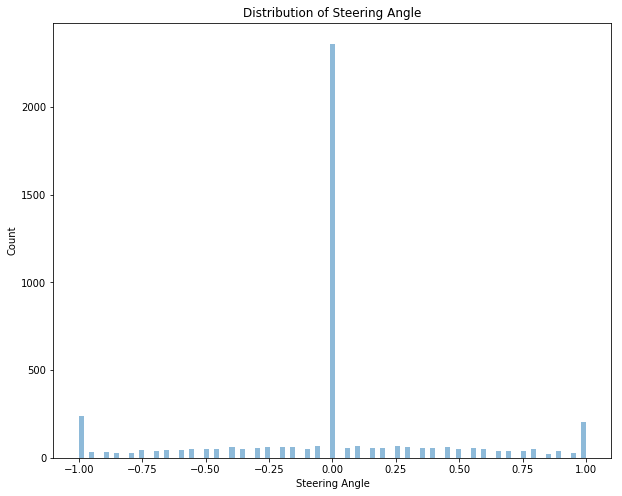

In [19]:
# Check the distribution of the target variable
plt.figure(figsize = (10,8));
plt.hist(steering, bins=101, alpha=0.5)
plt.xlabel("Steering Angle")
plt.ylabel("Count")
plt.title("Distribution of Steering Angle");

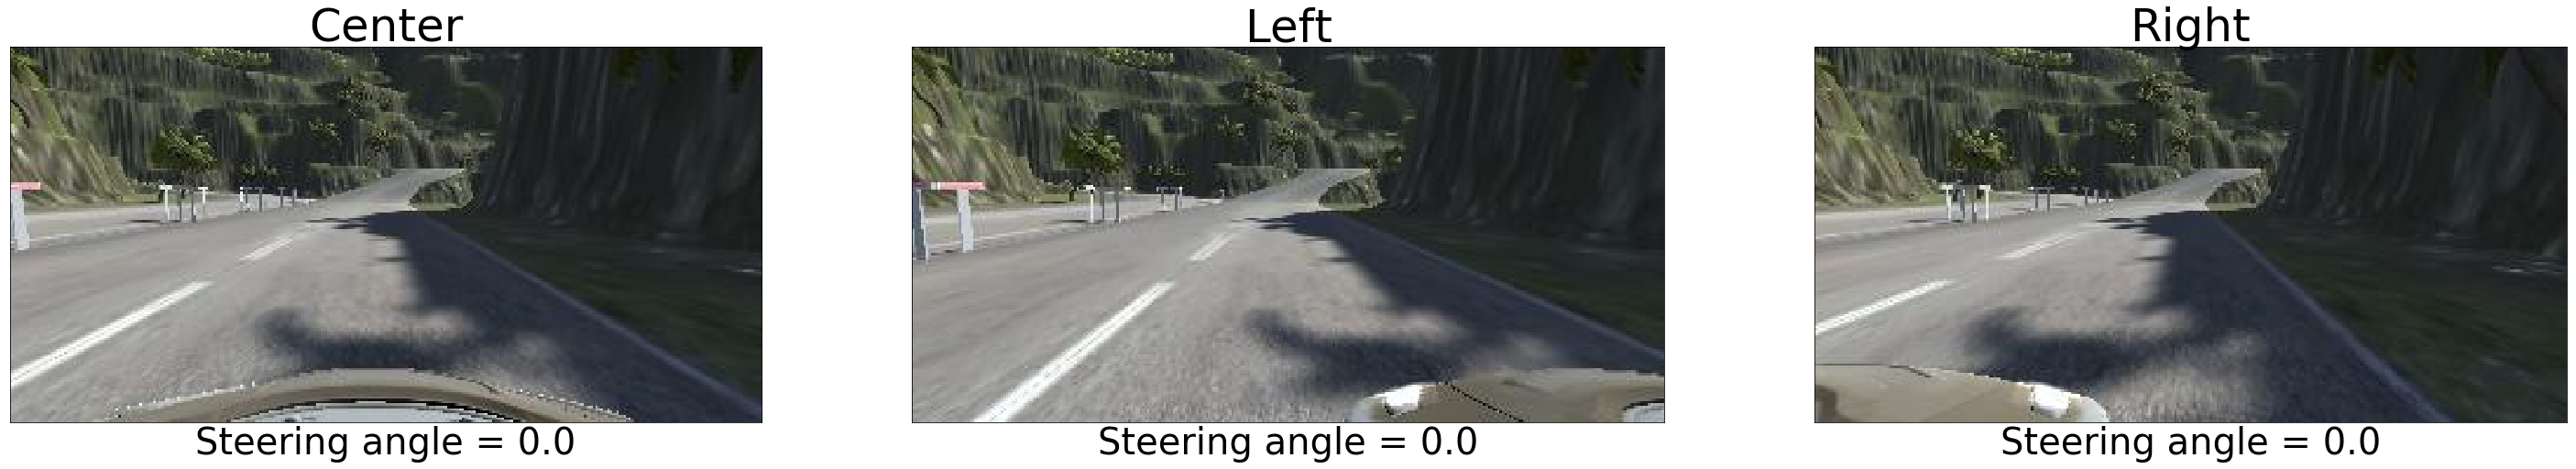

In [20]:
# Example images from center, left and right
images = [PIL.Image.fromarray(center[0]), PIL.Image.fromarray(left[0]), PIL.Image.fromarray(right[0])]
title = ['Center', 'Left', 'Right']

fig, axes = plt.subplots(1,3, figsize = (50,50))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(title[i], fontsize = 50)
    ax.set_xlabel('Steering angle = ' + str(round(steering[0], 4)), fontsize = 40)
    ax.set_xticks([])
    ax.set_yticks([])

## Image Augmentation with Angle Correction

In [21]:
# Flip each images with inverse steering angels and adjust the steering angle
def flip_images(images, angle, corr=0):
    aug_imgs = []
    aug_angle = []
    for image, angle in zip(images, angle):
        corr_angle = angle + corr
        aug_imgs.append(image)
        aug_angle.append(corr_angle)
        aug_imgs.append(cv2.flip(image, 1))
        aug_angle.append(corr_angle * -1)
    return (aug_imgs, aug_angle)

In [22]:
# Get the pixel and the steering angle
# Adjust right and left steering angle to account off center camera position
aug_imgs_ct, aug_angle_ct = flip_images(center, steering)
aug_imgs_lt, aug_angle_lt = flip_images(left, steering, corr = 0.15)
aug_imgs_rt, aug_angle_rt = flip_images(right, steering, corr = -0.15)

# Combine all of the image and steering values
aug_imgs = aug_imgs_ct + aug_imgs_lt + aug_imgs_rt
aug_str = aug_angle_ct + aug_angle_lt + aug_angle_rt

# Assign image value to predictor and steering value to target variable
X_train = np.array(aug_imgs)
y_train = np.array(aug_str)

In [23]:
# Check the length of the feature and target variable
print(len(X_train))
print(len(y_train))

28008
28008


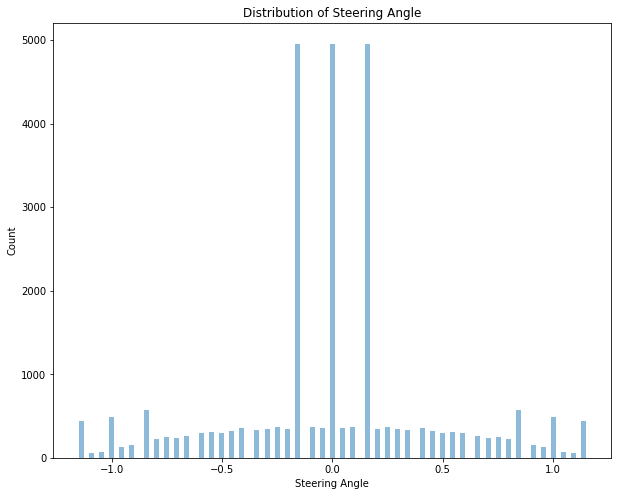

In [24]:
# Check the distribution of the target variable
plt.figure(figsize = (10,8));
plt.hist(aug_str, bins=101, alpha=0.5)
plt.xlabel("Steering Angle")
plt.ylabel("Count")
plt.title("Distribution of Steering Angle");

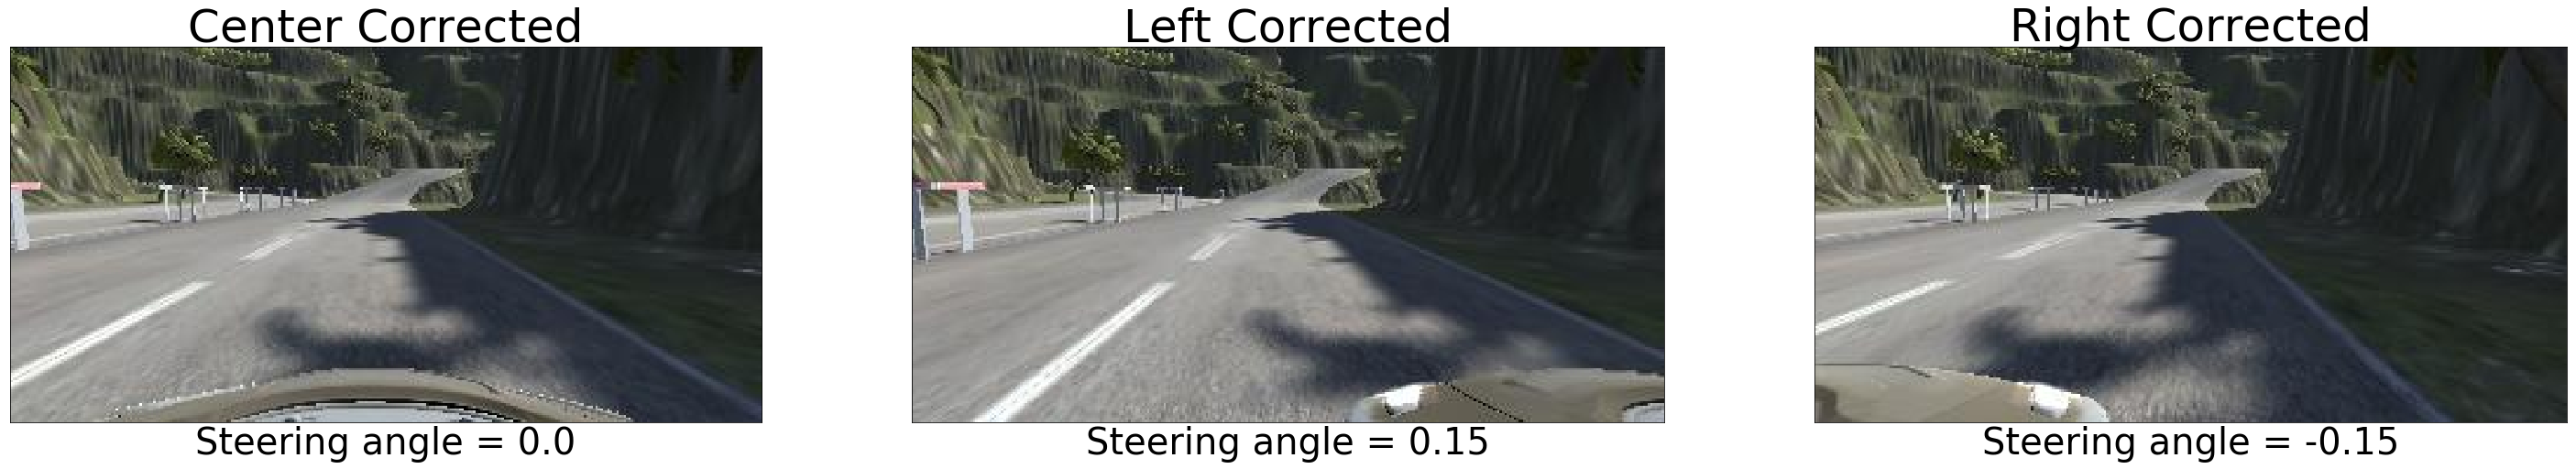

In [25]:
# Example images from center, left and right with correct steering angle
images = [PIL.Image.fromarray(aug_imgs_ct[0]), 
          PIL.Image.fromarray(aug_imgs_lt[0]), 
          PIL.Image.fromarray(aug_imgs_rt[0])]
title = ['Center Corrected', 'Left Corrected', 'Right Corrected']
angle = [aug_angle_ct[0], aug_angle_lt[0], aug_angle_rt[0]]

fig, axes = plt.subplots(1,3, figsize = (50,50))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(title[i], fontsize = 50)
    ax.set_xlabel('Steering angle = ' + str(round(angle[i], 4)), fontsize = 40)
    ax.set_xticks([])
    ax.set_yticks([])

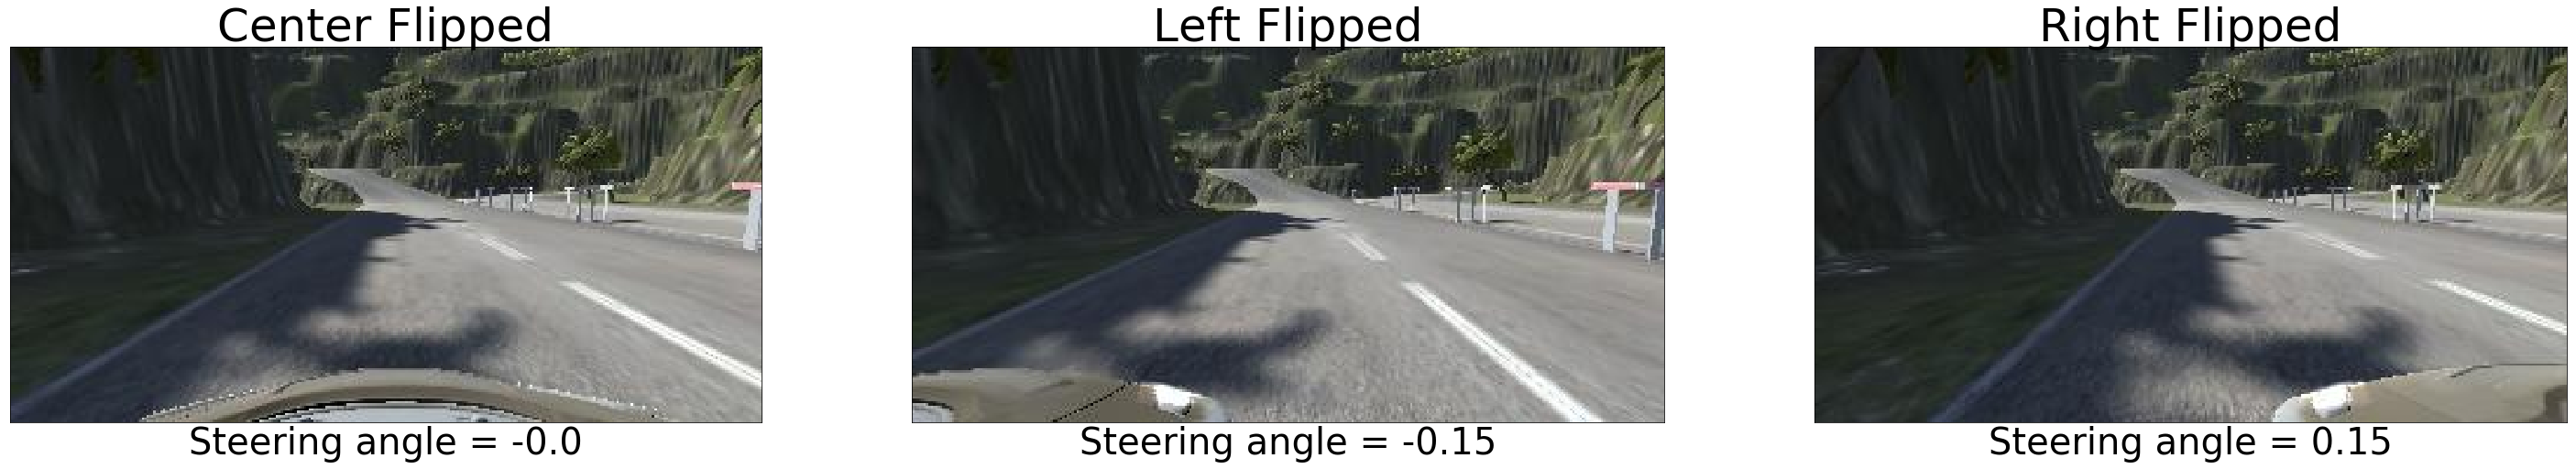

In [26]:
# Example flipped images from center, left and right with correct steering angle
images = [PIL.Image.fromarray(aug_imgs_ct[1]), 
          PIL.Image.fromarray(aug_imgs_lt[1]), 
          PIL.Image.fromarray(aug_imgs_rt[1])]
title = ['Center Flipped', 'Left Flipped', 'Right Flipped']
angle = [aug_angle_ct[1], aug_angle_lt[1], aug_angle_rt[1]]

fig, axes = plt.subplots(1,3, figsize = (50,50))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(title[i], fontsize = 50)
    ax.set_xlabel('Steering angle = ' + str(round(angle[i], 4)), fontsize = 40)
    ax.set_xticks([])
    ax.set_yticks([])

## Cropping Images

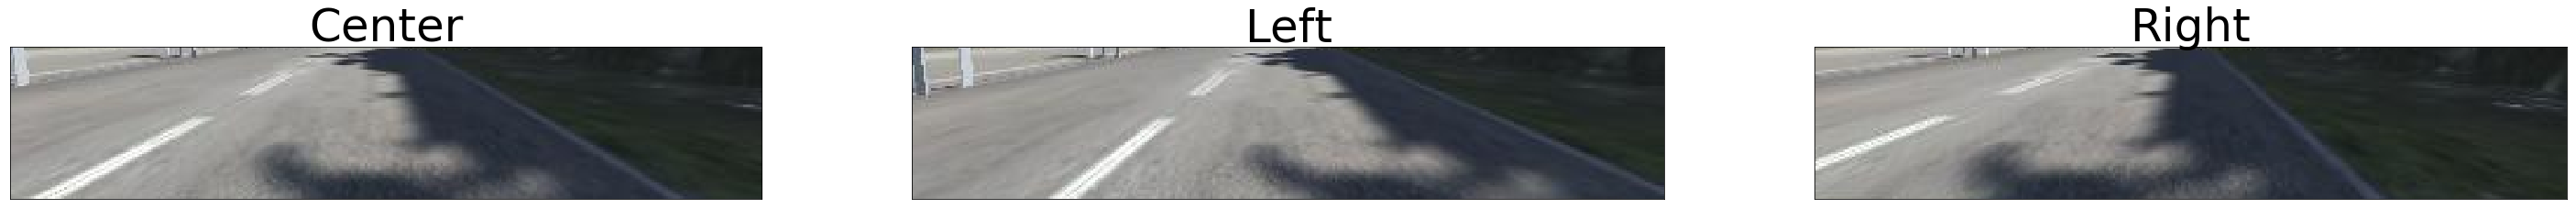

In [27]:
# Example of cropped image (input of the model)
images = [PIL.Image.fromarray(center[0][70:-25]),
          PIL.Image.fromarray(left[0][70:-25]), 
          PIL.Image.fromarray(right[0][70:-25])]
title = ['Center', 'Left', 'Right']

fig, axes = plt.subplots(1,3, figsize = (50,50))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(title[i], fontsize = 50)
    ax.set_xticks([])
    ax.set_yticks([])

## Convolutional Neural Network (CNN)

In [8]:
# Convolutional deep neural network based on the NVIDIA network. RUN in AWS
model = Sequential()
model.add(Cropping2D(cropping=((70, 25), (0, 0)))) # Cuts 70 from top of the image and 25 from bottom of the image
model.add(Lambda(lambda x: x / 205.5 - 0.5)) # Custome normalization function
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

fit_hist = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 5)

model.save('cnn_model.h5')
model.summary()

Train on 22406 samples, validate on 5602 samples
Epoch 1/5
22406/22406 [==============================] - 321s 14ms/step - loss: 0.1284 - val_loss: 0.0952
Epoch 2/5
22406/22406 [==============================] - 262s 12ms/step - loss: 0.1024 - val_loss: 0.0968
Epoch 3/5
22406/22406 [==============================] - 255s 11ms/step - loss: 0.0967 - val_loss: 0.0862
Epoch 4/5
22406/22406 [==============================] - 253s 11ms/step - loss: 0.0908 - val_loss: 0.0915
Epoch 5/5
22406/22406 [==============================] - 255s 11ms/step - loss: 0.0887 - val_loss: 0.0872
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)        

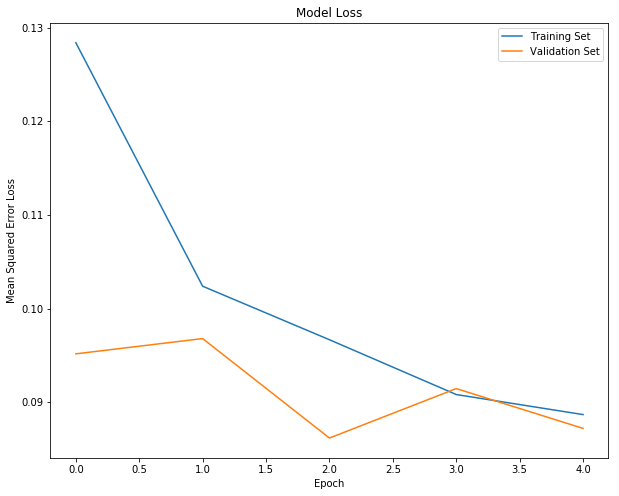

In [9]:
# Plot the training set and validation set losses
plt.figure(figsize = (10,8))
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()